In [1]:
# General imports
import time
import numpy as np

# Qiskit to create the circuit
from qiskit.circuit import QuantumCircuit, Parameter

# SciPy minimizer routine
from scipy.optimize import minimize
from custom_optimizers import *


# Plotting functions
import matplotlib.pyplot as plt


# Libraries to create the Hamiltonian as SparseOp
from qiskit_nature.second_q.drivers import PySCFDriver

import qiskit_nature
from qiskit_nature.second_q.mappers import JordanWignerMapper
qiskit_nature.settings.use_pauli_sum_op = False

# To simulate locally. Ref here https://qiskit.org/ecosystem/ibm-runtime/migrate/migrate-estimator.html#b-new-use-the-reference-estimator-or-aer-estimator-primitive
from qiskit_aer.primitives import Estimator


In [2]:
train_points_indexes = [2,6,10,14,18]

test_points = np.arange(0.6,5,0.2)

train_points = np.array([test_points[i] for i in train_points_indexes])

test_hamiltonians = []

for d in test_points:
    coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, d]) 

    driver = PySCFDriver(
        atom=["H 0 0 0; H 0 0 "+str(d) ] 
    )
    molecule = driver.run()

    fermionic_operator = molecule.second_q_ops()[0]

    hamiltonian = JordanWignerMapper().map(second_q_ops = fermionic_operator)    

    
    test_hamiltonians.append(hamiltonian)
    
train_hamiltonians = [test_hamiltonians[i] for i in train_points_indexes]

print("===== TRAIN POINTS =====")
print(train_points)

===== TRAIN POINTS =====
[1.  1.8 2.6 3.4 4.2]


In [3]:
def gaussian_encoding(param_array, r):
    """1-D array with alphas, betas, gammas and deltas. len(param_array) = 4 * len(weights) 

    Args:
        param_array (float): , betas, gammas and deltas for gaussian encoding
        r(float): Hamiltonian parameter (in this case, distance)
    """

    exp_arg = param_array[1::4]*(param_array[2::4] - r)

    return (param_array[::4]*np.exp(exp_arg) + param_array[3::4]).item() ## .item() to pass a number

In [4]:
def double_ex_ansatz(qubits, param, init_state = [1,1,0,0]):
    theta = Parameter('theta')

    double_ex = QuantumCircuit(qubits, 0)

    for count,q in enumerate(init_state):
        if(q == 1):
            double_ex.x(count)

    double_ex.cx(2, 3)
    double_ex.cx(0, 2)
    double_ex.h(3)
    double_ex.h(0)
    double_ex.cx(2, 3)
    double_ex.cx(0, 1)
    double_ex.ry(0.125*theta, 1)
    double_ex.ry(-0.125*theta, 0)
    double_ex.cx(0, 3)
    double_ex.h(3)
    double_ex.cx(3, 1)
    double_ex.ry(0.125*theta, 1)
    double_ex.ry(-0.125*theta, 0)
    double_ex.cx(2, 1)
    double_ex.cx(2, 0)
    double_ex.ry(-0.125*theta, 1)
    double_ex.ry(0.125*theta, 0)
    double_ex.cx(3, 1)
    double_ex.h(3)
    double_ex.cx(0, 3)
    double_ex.ry(-0.125*theta, 1)
    double_ex.ry(0.125*theta, 0)
    double_ex.cx(0, 1)
    double_ex.cx(2, 0)
    double_ex.h(0)
    double_ex.h(3)
    double_ex.cx(0, 2)
    double_ex.cx(2, 3)


    double_ex_binded = double_ex.bind_parameters( {theta: param} )

    return double_ex_binded


In [5]:
num_params = 4
x0 = 2 * np.pi * np.random.random(num_params)
x0


tensor([0.43685664, 4.36296941, 2.29844345, 0.88050383], requires_grad=True)

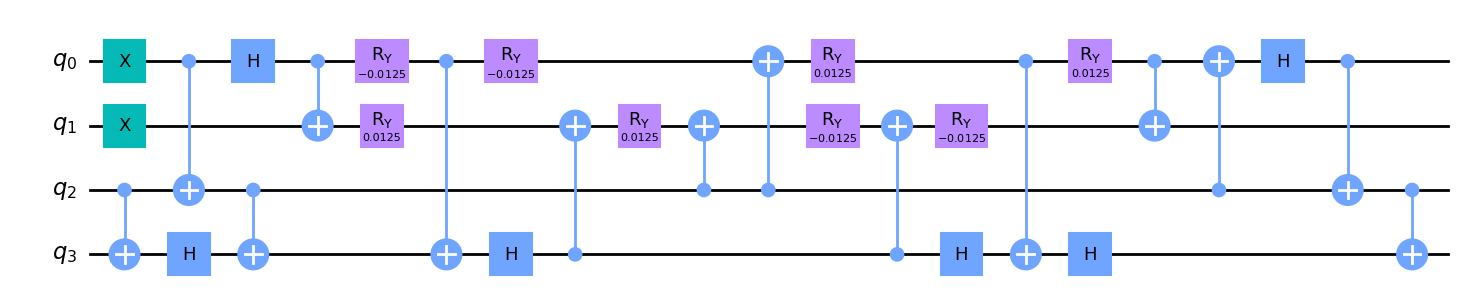

In [6]:
test_ansatz = double_ex_ansatz(4,0.1)

test_ansatz.draw(output='mpl')

In [7]:
estimator = Estimator(run_options= {"method": "statevector"})

expectation_value = estimator.run(test_ansatz, train_hamiltonians[0], counts=20).result()
expectation_value

EstimatorResult(values=array([-1.27630792]), metadata=[{'shots': 14336, 'variance': 0.010445779666186913, 'simulator_metadata': [{'parallel_state_update': 4, 'sample_measure_time': 0.000401842, 'noise': 'ideal', 'batched_shots_optimization': False, 'measure_sampling': True, 'device': 'CPU', 'num_qubits': 4, 'parallel_shots': 1, 'remapped_qubits': False, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3], 'num_clbits': 1, 'input_qubit_map': [[3, 3], [2, 2], [0, 0], [1, 1]], 'fusion': {'applied': False, 'max_fused_qubits': 5, 'enabled': True, 'threshold': 14}}, {'parallel_state_update': 4, 'sample_measure_time': 0.000367679, 'noise': 'ideal', 'batched_shots_optimization': False, 'measure_sampling': True, 'device': 'CPU', 'num_qubits': 4, 'parallel_shots': 1, 'remapped_qubits': False, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3], 'num_clbits': 1, 'input_qubit_map': [[3, 3], [2, 2], [0, 0], [1, 1]], 'fusion': {'applied': False, 'max_fused_qubits': 5, 'enabled': Tr

In [8]:
def cost_func( params, qubits, ansatz_fun, distances, hamiltonians, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz_fun (function): Creates the Parameterized ansatz circuit
        distances (ndarray): Array of distances set as training points
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    # print("params to try:", params)

    circuits =[ansatz_fun(qubits,  gaussian_encoding(params,distance), init_state = [1,1,0,0]) for distance in distances]


    energies  = estimator.run(circuits, hamiltonians).result().values
    cost = sum(energies)/len(hamiltonians)
    # print("on cost run:",energies, cost)
    return cost

In [9]:
cost_func(x0,4,double_ex_ansatz,train_points, train_hamiltonians, estimator)

-1.151202508913046

In [10]:
res_demon = minimize(cost_func, x0,args=(4,double_ex_ansatz,train_points, train_hamiltonians, estimator), method = adam, options = {'qubits':4, 'ansatz_fun': double_ex_ansatz, 'distances':train_points, 'hamiltonians':train_hamiltonians, 'estimator':estimator, 'maxiter': 120, 'tol':1e-5, 'demon':True, 'verbose':True})


ADAM - Step:  0  Cost:  -1.1527032383474212
ADAM - Step:  10  Cost:  -1.151382025720539
ADAM - Step:  20  Cost:  -1.1497666320772126
ADAM - Step:  30  Cost:  -1.1548113660918224
ADAM - Step:  40  Cost:  -1.1523846150399368
ADAM - Step:  50  Cost:  -1.1558505547772173
Finished ADAM training


In [11]:
res_demon

 fun: [-1.1511705358129642, -1.1527032383474212, -1.1534751073665812, -1.1548407885014178, -1.1500756970317028, -1.1531968679494735, -1.1533849971621712, -1.1549367852547554, -1.1522267914097795, -1.1494531321725154, -1.1553465784609736, -1.151382025720539, -1.1563908492510122, -1.153266715733072, -1.1570869141265048, -1.1515540013721737, -1.1526589427938183, -1.1527117390115893, -1.1520519040155643, -1.1538720510266234, -1.1551700338393993, -1.1497666320772126, -1.155046039569045, -1.156148261049361, -1.15281292108836, -1.1542354010496416, -1.1572110807497142, -1.1556207473843383, -1.1565986219902693, -1.153746495924218, -1.1501051859963005, -1.1548113660918224, -1.1564176015994163, -1.1549902547057642, -1.152465578922472, -1.154341557275756, -1.1528948476386742, -1.1553974837827223, -1.1560181115951216, -1.152780213622786, -1.156488760758243, -1.1523846150399368, -1.1564864053664474, -1.1526013436458502, -1.1525721450226842, -1.1539944209401232, -1.1533715795636295, -1.15101491765130

In [ ]:
# The IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Session

service = QiskitRuntimeService()
backend = service.get_backend("ibmq_qasm_simulator")

In [ ]:
# with Session(backend=backend):
#     estimator = Estimator(options={"shots": int(1e3)})
#     res = minimize(
#         cost_func, x0, args=(double_ex_ansatz, train_hamiltonians, estimator), method="cobyla", tol=1e-3
#     )